In [1]:
from pkg.src.core import factors


f = factors.MultiFactors(tickers="SPY, AGG", factors=[factors.PriceMomentum12M])


f.standard_percentile

,SPY,AGG
Date,,
2004-09-29,0.76025,0.23975
2004-09-30,0.76025,0.23975
2004-10-01,0.76025,0.23975
2004-10-04,0.76025,0.23975
2004-10-05,0.76025,0.23975
...,...,...
2023-06-09,0.76025,0.23975
2023-06-12,0.76025,0.23975
2023-06-13,0.76025,0.23975


In [6]:
"""ROBERT"""
from typing import Optional
import pandas as pd
from pkg.src.data import get_prices

__all__ = [
    "Global64",
    "UnitedStates64",
]


class Benchmark:
    def __init__(
        self,
        prices: pd.DataFrame,
        allocations: pd.Series,
        name: Optional[str] = None,
    ) -> None:
        self.name = name
        self.prices = prices.ffill().dropna()
        self.allocations = allocations

    def __repr__(self) -> str:
        details = "; ".join(
            [f"{asset}: {weight:.2%}" for asset, weight in self.allocations.items()]
        )
        return f"Benchmark ({details})"

    def __str__(self) -> str:
        if self.name is not None:
            return self.name
        return self.__repr__()

    def performance(
        self,
        initial_investment: int = 10_000,
        start: Optional[str] = None,
        end: Optional[str] = None,
    ) -> pd.Series:
        prices = self.prices.copy()
        if start is not None:
            prices = prices.loc[start:]
        if end is not None:
            prices = prices.loc[:end]
        weights = pd.Series(self.allocations)
        perf = (
            prices.pct_change()
            .fillna(0)
            .dot(weights)
            .add(1)
            .cumprod()
            .multiply(initial_investment)
        )
        perf.name = str(self)
        return perf


class Global64(Benchmark):
    allocations: pd.Series = pd.Series({"ACWI": 0.6, "BND": 0.4})

    @classmethod
    def instance(cls) -> Benchmark:
        name = "global64"
        prices = get_prices(tickers=list(cls.allocations.keys())).ffill().dropna()
        return cls(prices=prices, allocations=cls.allocations, name=name)


class UnitedStates64(Benchmark):
    @classmethod
    def instance(cls) -> Benchmark:
        name = "US64"
        allocations = pd.Series({"SPY": 0.6, "AGG": 0.4})
        prices = get_prices(tickers=list(allocations.keys())).ffill().dropna()
        return cls(prices=prices, allocations=allocations, name=name)


Global64.instance().performance()

Date
2008-03-28    10000.000000
2008-03-31     9920.455279
2008-04-01    10039.723989
2008-04-02    10101.113246
2008-04-03    10133.860682
                  ...     
2023-06-08    22102.179153
2023-06-09    22102.374576
2023-06-12    22216.955418
2023-06-13    22281.009759
2023-06-14    22369.891568
Name: global64, Length: 3831, dtype: float64

In [ ]:
from pydantic import BaseModel

In [ ]:
from enum import Enum

In [56]:
"""ROBERT"""

from pkg.src.data import get_prices

class Benchmark:
    @property
    def weights(self) -> pd.Series:
        return pd.Series(
            {
                asset: weight
                for asset, weight in self.__class__.__dict__.items()
                if not asset.startswith("__")
            }
        )

    @property
    def prices(self) -> pd.DataFrame:
        return get_prices(tickers=list(self.weights.keys())).ffill().dropna()

    def performance(
        self,
        initial_investment: int = 10_000,
        start: Optional[str] = None,
        end: Optional[str] = None,
    ) -> pd.Series:
        prices = self.prices.copy()
        if start is not None:
            prices = prices.loc[start:]
        if end is not None:
            prices = prices.loc[:end]
        perf = (
            prices.pct_change()
            .fillna(0)
            .dot(self.weights)
            .add(1)
            .cumprod()
            .multiply(initial_investment)
        )
        perf.name = self.__str__()
        return perf

    def __str__(self) -> str:
        return f"<Benchmark {self.weights.to_dict()}>"


class Global64(Benchmark):
    ACWI = 0.6
    BND = 0.4


class UnitedStates64(Benchmark):
    SPY = 0.6
    AGG = 0.4


# Create an instance of the Benchmark class

UnitedStates64().performance()

Date
2003-09-29    10000.000000
2003-09-30     9962.490400
2003-10-01    10087.933080
2003-10-02    10103.583348
2003-10-03    10130.025091
                  ...     
2023-06-08    41277.387549
2023-06-09    41283.155457
2023-06-12    41536.518455
2023-06-13    41622.951511
2023-06-14    41716.351309
Name: <Benchmark {'SPY': 0.6, 'AGG': 0.4}>, Length: 4962, dtype: float64

In [1]:
from pkg.src.core.portfolios import BaseOptimizer
from pkg.src.data import get_prices


prices = get_prices("SPY, AGG, GSG, TLT, IEF")

opt = BaseOptimizer.from_prices(prices=prices)

opt.set_bounds(
    weight=(0, 1), port_return=(0.02, 0.05)
)

opt.constraints

{'sum_weight': {'type': 'eq',
  'fun': <function pkg.src.core.portfolios.base.BaseOptimizer.set_sum_weight.<locals>.<lambda>(w)>},
 'min_weight': {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.base.BaseOptimizer.set_max_weight.<locals>.<lambda>(w)>},
 'min_port_return': {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.base.BaseOptimizer.set_min_port_return.<locals>.<lambda>(w)>},
 'max_port_return': {'type': 'ineq',
  'fun': <function pkg.src.core.portfolios.base.BaseOptimizer.set_max_port_return.<locals>.<lambda>(w)>}}

In [2]:
opt.maximized_return()

SPY    0.258356
AGG    0.190443
GSG    0.143262
TLT    0.210456
IEF    0.197482
Name: weights, dtype: float64

In [6]:
from pkg.src.core import factors

type(factors.PriceMomentum12M) == type(factors.Factors)

True

In [7]:
type(factors.Factors)

type

<AxesSubplot:>

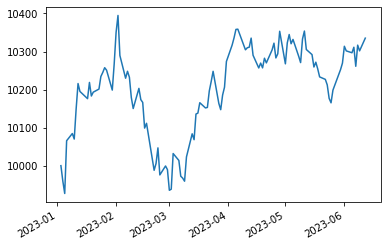

In [2]:
from pkg.src import core, data
import pandas as pd

prices = data.get_prices("SPY, AGG")
weights_bm = pd.Series(dict(SPY=0.4, AGG=0.6))

bt = core.BacktestManager(shares_frac=0).run(
    prices=prices, start="2023-1-1", objective="risk_parity"
)

bt.value.plot()

In [4]:
from pkg.src.data import get_universe

get_universe().to_json("metadata.json", orient="records")

In [ ]:
bt.data["shares"]

In [ ]:
import pandas as pd

prices.pct_change().dot(weights_bm).loc["2023-1-3":].add(1).cumprod().plot()
bt.prices_bm

In [ ]:
bt

In [ ]:
cc.groupby("quantile").mean().plot.bar()

In [ ]:
quantile = to_quantile(factorsdata).dropna(thresh=6)

In [ ]:
import numpy as np
from scipy import stats


def factor_information_coefficient(
    factor_data, group_adjust=False, by_group=False, method=stats.spearmanr
):
    def src_ic(group):
        f = group["factor"]
        _ic = group[["period_1", "period_252"]].apply(lambda x: method(x, f)[0])
        return _ic

    factor_data = factor_data.copy()

    grouper = [factor_data.index.get_level_values("date")]

    # if group_adjust:
    #     factor_data = demean_forward_returns(factor_data, grouper + ['group'])
    # if by_group:
    #     grouper.append('group')

    with np.errstate(divide="ignore", invalid="ignore"):
        ic = factor_data.groupby(grouper).apply(src_ic)

    return ic


ic = factor_information_coefficient(far.clean_factor_data)

ic.plot()

In [ ]:
ic.mean()

In [ ]:
far = ja.FactorAnalyzer(
    prices=prices,
    factor=factorsdata,  # factor_data 为因子值的 pandas.DataFrame
    quantiles=10,
    periods=(1, 252),
    max_loss=0.9,
)

far

In [ ]:
far._clean_factor_data

In [ ]:
from pkg.src.core import signals, data
import pandas as pd

df = data.get_oecd_us_leading_indicator()
df.index = df.index + pd.DateOffset(months=1)
df = df.resample("M").last().dropna()

df = df.diff()
mean = df.rolling(12 * 5).mean()
std = df.rolling(12 * 5).std()
normalized = (df - mean) / std

normalized = normalized.clip(-3, 3).dropna()

import plotly.graph_objects as go


# Create the bar plot
fig = go.Figure(data=go.Bar(x=normalized.index, y=normalized["USALOLITONOSTSAM"]))

# Customize the plot layout
fig.update_layout(title="Bar Plot", xaxis_title="Categories", yaxis_title="Values")

# Display the plot
fig.show()

In [ ]:
normalized

In [ ]:
trend.loc["2015"]

In [ ]:
from pkg.src.core import data, metrics
import numpy as np
import pandas as pd

total_iter = 12 * 20 * 10
prices = data.get_prices("SPY, AGG, TLT").resample("M").last()

log_return = metrics.to_log_return(prices=prices)
expected_return = log_return.mean()
expected_riks = log_return.std()
cov = log_return.cov()
corr_cov = np.linalg.cholesky(cov)
z = np.random.normal(0, 1, size=(len(prices.columns), total_iter))

drift = np.full((total_iter, len(prices.columns)), expected_return).T
shock = np.dot(corr_cov, z)

monthly_returns = drift + shock
pd.DataFrame(
    np.transpose(monthly_returns),
    columns=prices.columns,
    # index=pd.date_range(start="2023-6-8", periods=total_iter, freq="M"),
).cumsum().plot()

In [ ]:
import pandas as pd


def to_macd(
    prices: pd.DataFrame,
    fast_window: int = 12,
    slow_window: int = 26,
    signal_window: int = 9,
) -> pd.DataFrame:
    MACD = (
        +prices.ewm(span=fast_window, min_periods=fast_window).mean()
        - prices.ewm(span=slow_window, min_periods=slow_window).mean()
    )
    signal = MACD.ewm(span=signal_window, min_periods=slow_window).mean()

    return signal


to_macd(prices).loc["2022"].plot()

In [ ]:
(
    prices.ewm(span=12, min_periods=12).mean()
    - prices.ewm(span=26, min_periods=26).mean()
).plot()

In [ ]:
yield_curve = {"T10Y2Y": "10Y-2Y", "T10Y3M": "10Y-3M"}

yield_curve_data = data.get_macro(list(yield_curve.keys())).loc["2019":]
yield_curve_data = yield_curve_data.rename(columns=yield_curve)
yield_curve_data.head().to_markdown()

In [ ]:
import plotly_express as px

px.line(yield_curve_data)

In [ ]:
my_list = [10, 20, 30, 40, 50]

# Get the index of a value in the list
value = 30

if value in my_list:
    index = my_list.index(value)
    print("Index of", value, "in the list:", index)
else:
    print(value, "is not present in the list.")

In [ ]:
from pkg.src.core.factors import price_momentum_diffusion
from pkg.src.core import data

price_momentum_diffusion(tickers="SPY, ACWI, XLY, XLP, AGG")

In [ ]:
from pkg.src.core import metrics
import numpy as np
import pandas as pd

prices = data.get_prices(tickers="SPY, ACWI, XLY, XLP, AGG")
momentums = (
    pd.concat(
        objs=[
            metrics.rolling.to_momentum(prices=prices, months=1).stack(),
            metrics.rolling.to_momentum(prices=prices, months=2).stack(),
            metrics.rolling.to_momentum(prices=prices, months=3).stack(),
            metrics.rolling.to_momentum(prices=prices, months=6).stack(),
            metrics.rolling.to_momentum(prices=prices, months=9).stack(),
            metrics.rolling.to_momentum(prices=prices, months=12).stack(),
        ],
        axis=1,
    )
    .apply(np.sign)
    .sum(axis=1)
    .unstack()
)

momentums

In [ ]:
from pkg.src.core import factors

factors.volatility_3m(tickers="SPY, AGG")

In [ ]:
from pkg.src.core import data

data.get_universe()

In [ ]:
from pkg.src.core.metrics.rolling import to_momentum
from pkg.src.core import data
from pkg.src.core.strategies import BacktestManager
import pandas as pd
from scipy.stats import norm


def to_standard_scalar(features: pd.Series) -> pd.Series:
    scalar = (features - features.mean()) / features.std()
    return scalar


def to_standard_percentile(features: pd.Series) -> pd.Series:
    return to_standard_scalar(features=features).aggregate(norm.cdf)


prices = data.get_prices("XLC, XLY, XLP, XLE, XLF, XLV, XLI, XLB, XLRE, XLK, XLU")

bt = BacktestManager(prices=prices)
features = to_momentum(prices=prices, months=12).apply(to_standard_percentile, axis=1)

bt.Base(name="Strategy1", start="2013-1-1", features=features, percentile=0.8)
#
bt.strategies["Strategy1"].allocations
# features
bt.strategies["Strategy1"].value.plot()

In [ ]:
from pkg.src.core import feature

functions = [func for func in dir(feature) if callable(getattr(feature, func))]
functions

In [ ]:
pri_momentum = data.price_momentum_1m(tickers="SPY, AGG")
pri_momentum

In [ ]:
import json

# from core.signals import OECDUSLEIHP
from pkg.core.strategies import BacktestManager

# signal = OECDUSLEIHP.from_fred_data()


def get_universe(name: str = "USSECTOR"):
    with open("universe.json") as f:
        return json.load(f).get(name)


from pkg.src.core import data

prices = data.get_prices(tickers=list(get_universe().keys()))
bt = BacktestManager(prices=prices, start="2007-1-1", commission=10, shares_frac=0)
# bt.Momentum(target_percentile=0.7, months=3)
# bt.values.plot(figsize=(12, 10))
# bt.analytics

from core import metrics

metrics.to_momentum(prices=prices.iloc[:, 0], months=12, skip_months=1)

In [ ]:
from pkg.src.core import data


data.get_universe()

In [ ]:
opt = Optimizer.from_prices(prices=prices.loc["2017"].dropna(axis=1))

w = opt.hierarchical_risk_parity()

w

In [ ]:
from pkg.src.core.portfolios import objectives

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[8],
    )
)

np.sum(
    objectives.risk_contributions(
        weights=w,
        covariance_matrix=np.array(opt.covariance_matrix),
        sub_covariance_matrix_idx=[0, 3],
    )
)

In [ ]:
objectives.expected_volatility(w, opt.covariance_matrix)

In [ ]:
dist = np.sqrt((1 - opt.correlation_matrix).round(5) / 2)
clusters = linkage(squareform(dist), method="single")
sorted_tree = list(to_tree(clusters, rd=False).pre_order())

print(sorted_tree)


def recursive_bisection(sorted_tree):
    """_summary_

    Args:
        sorted_tree (_type_): _description_

    Returns:
        List[Tuple[List[int], List[int]]]: _description_
    """

    left = sorted_tree[0 : int(len(sorted_tree) / 2)]
    right = sorted_tree[int(len(sorted_tree) / 2) :]

    if len(sorted_tree) < 3:
        return (left, right)

    cache = [(left, right)]
    if len(left) > 2:
        cache.extend(recursive_bisection(left))
    if len(right) > 2:
        cache.extend(recursive_bisection(right))
    return cache


cluster_sets = recursive_bisection(sorted_tree)

for i in cluster_sets:
    print(i)

In [ ]:
from core import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tickers = {
    "T5YIE": "Breakeven Inflation: 5Y",
    "T10YIE": "Breakeven Inflation: 10Y",
    "T5YIFR": "Expectation Infaltiona: 5Y",
}

result = data.get_macro(tickers=tickers).dropna()
result["chg"] = result["Breakeven Inflation: 10Y"] - result["Breakeven Inflation: 5Y"]
spy = data.get_prices(tickers="SPY")

# Create a line plot for each series
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(
    go.Scatter(x=spy.index, y=spy["SPY"], mode="lines", name="SPY"), row=1, col=1
)
for series in result:
    fig.add_trace(
        go.Scatter(x=result.index, y=result[series], mode="lines", name=series),
        row=2,
        col=1,
    )

# Set the title and axis labels
fig.update_layout(title="Inflation", xaxis_title="Date", yaxis_title="%", height=600)
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=False),
        type="date",
    ),
    hovermode="x unified",  # Enable the "Show All Stats" option on mouseover
)

# Display the graph
fig.show()

In [ ]:
from core.strategies import BacktestManager

bt = BacktestManager.from_universe(start="2010-1-1", commission=10, shares_frac=0)
bt.Momentum()
bt.values.plot()